# Assignment 1: Genomics Annotation Analysis

**Objective:**  
Analyze annotated VCFs from Ensembl VEP to extract key variant statistics.

**Goals:**  
1. Count total variants  
2. Count unique genes  
3. Count unique disease/trait entries  
4. List pathogenic / likely pathogenic variants  
5. Count variants per chromosome and detect missing SNP IDs  
6. Generate a comprehensive summary log (CSV output)

**Input Files:**  
- `test1_first50_vep_output.vcf`  
- `test2_first50_vep_output.vcf`

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [31]:
# === Define directories ===
VCF_DIR = os.path.expanduser('~/clovertex_assignment/vcfs')
OUT_DIR = os.path.expanduser('~/clovertex_assignment/assignment_1_genomics_annotation/results')
os.makedirs(OUT_DIR, exist_ok=True)

In [32]:
# === Load your VCFs (current 50-variant test files) ===
test1_vcf = os.path.join(VCF_DIR, 'test1_first50_vep_output.vcf')
test2_vcf = os.path.join(VCF_DIR, 'test2_first50_vep_output.vcf')

In [33]:
# --- Parse VCF lines (auto-handle 8–10 columns) ---
def load_vcf(path):
    rows = []
    with open(path) as f:
        for line in f:
            if not line.startswith("#"):
                rows.append(line.strip().split("\t"))

    # Determine correct number of columns
    if not rows:
        raise ValueError(f"No variant lines found in {path}")
    col_count = len(rows[0])

    # Assign headers dynamically
    if col_count == 8:
        cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]
    elif col_count == 9:
        cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
    elif col_count == 10:
        cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMPLE"]
    else:
        cols = [f"col{i}" for i in range(col_count)]  # fallback safety

    df = pd.DataFrame(rows, columns=cols)
    return df

df1 = load_vcf(test1_vcf)
df2 = load_vcf(test2_vcf)

In [34]:
print(f"✅ Loaded VCFs successfully: test1 = {len(df1)} variants, test2 = {len(df2)} variants")
print("✅ Columns in test1:", df1.columns.tolist())

✅ Loaded VCFs successfully: test1 = 50 variants, test2 = 50 variants
✅ Columns in test1: ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']


In [35]:
print("Total Variants:")
print({
    "test1": len(df1),
    "test2": len(df2)
})

Total Variants:
{'test1': 50, 'test2': 50}


In [36]:
# --- Extract CSQ annotations from INFO ---
def extract_ann_df(df):
    rows = []
    for _, r in df.iterrows():
        if "CSQ=" in r["INFO"]:
            csq_part = r["INFO"].split("CSQ=")[1].split(";")[0]
            for e in csq_part.split(","):
                rows.append({"CHROM": r["CHROM"], "POS": r["POS"], "CSQ": e})
    return pd.DataFrame(rows)

expanded1 = extract_ann_df(df1)
expanded2 = extract_ann_df(df2)

print(f"✅ Extracted annotations: test1 = {len(expanded1)} rows, test2 = {len(expanded2)} rows")


✅ Extracted annotations: test1 = 560 rows, test2 = 581 rows


In [37]:
print(f"Expanded Test1: {len(expanded1)} entries")
print(f"Expanded Test2: {len(expanded2)} entries")

Expanded Test1: 560 entries
Expanded Test2: 581 entries


In [9]:
unique_genes = {
    "test1": expanded1["SYMBOL"].nunique(),
    "test2": expanded2["SYMBOL"].nunique()
}

print("Unique Gene Counts:")
print(unique_genes)# Cell 5: sanity & quick counts
def summarize_variants(df_vars, df_ann, sample_name):
    total_variants = len(df_vars)
    annotated_variant_count = df_ann[['CHROM','POS']].drop_duplicates().shape[0]
    # unique gene symbols (common CSQ field name is 'SYMBOL')
    gene_col = None
    for c in df_ann.columns:
        if c.upper() == 'SYMBOL' or c.lower() == 'symbol':
            gene_col = c
            break
    unique_genes = sorted(df_ann[gene_col].dropna().unique()) if gene_col else []
    # per-chrom counts
    chr_counts = df_vars['CHROM'].value_counts().to_dict()
    # rsID presence
    rsid_present = df_vars['ID'].apply(lambda x: x != '.' and x != '').sum()
    rsid_missing = total_variants - rsid_present

    summary = {
        'sample': sample_name,
        'total_variants': total_variants,
        'annotated_variant_count': annotated_variant_count,
        'unique_genes_count': len(unique_genes),
        'unique_genes_example': unique_genes[:10],
        'chr_counts': chr_counts,
        'rsid_present': int(rsid_present),
        'rsid_missing': int(rsid_missing)
    }
    return summary

s1 = summarize_variants(df1_vars, df1_ann, 'test1_50')
s2 = summarize_variants(df2_vars, df2_ann, 'test2_50')
pd.DataFrame([s1, s2])

,sample,total_variants,annotated_variant_count,unique_genes_count,unique_genes_example,chr_counts,rsid_present,rsid_missing
0,test1_50,50,50,0,[],{'1': 50},0,50
1,test2_50,50,50,0,[],{'MT': 50},50,0


In [41]:
def extract_disease_traits(df):
    # Find the correct column name for consequence info (case-insensitive)
    cons_col = next((c for c in df.columns if c.lower() == "consequence"), None)
    
    if cons_col:
        disease_like = df[df[cons_col].str.contains("disease|trait|clinical|syndrome", case=False, na=False)]
    else:
        print("⚠️ Warning: No 'Consequence' column found — returning empty DataFrame.")
        disease_like = pd.DataFrame()
    
    return disease_like

traits1 = extract_disease_traits(expanded1)
traits2 = extract_disease_traits(expanded2)

⚠️ Warning: No 'Consequence' column found — returning empty DataFrame.
⚠️ Warning: No 'Consequence' column found — returning empty DataFrame.


In [42]:
print("Test1: Traits/Disease annotations →", len(traits1))
print("Test2: Traits/Disease annotations →", len(traits2))

Test1: Traits/Disease annotations → 0
Test2: Traits/Disease annotations → 0


In [43]:
def find_pathogenic_variants(df):
    # Try to find the column that holds consequence info (case-insensitive)
    cons_col = next((c for c in df.columns if c.lower() == "consequence"), None)
    
    if not cons_col:
        print("⚠️ Warning: No 'Consequence' column found — returning empty DataFrames.")
        empty_df = pd.DataFrame()
        return empty_df, empty_df, empty_df

    # Pathogenic only
    patho = df[df[cons_col].str.contains(r"\bpathogenic\b", case=False, na=False)]
    # Likely pathogenic only
    likely_patho = df[df[cons_col].str.contains(r"likely\s*pathogenic", case=False, na=False)]
    # Combined set (union)
    combined = pd.concat([patho, likely_patho]).drop_duplicates()
    
    return patho, likely_patho, combined


# Apply the function to both datasets
patho1, likely1, combined1 = find_pathogenic_variants(expanded1)
patho2, likely2, combined2 = find_pathogenic_variants(expanded2)

# Print quick stats
print(f"✅ Test1: {len(patho1)} pathogenic, {len(likely1)} likely pathogenic, {len(combined1)} total combined")
print(f"✅ Test2: {len(patho2)} pathogenic, {len(likely2)} likely pathogenic, {len(combined2)} total combined")

# Show first few rows
combined1.head()

⚠️ Warning: No 'Consequence' column found — returning empty DataFrames.
⚠️ Warning: No 'Consequence' column found — returning empty DataFrames.
✅ Test1: 0 pathogenic, 0 likely pathogenic, 0 total combined
✅ Test2: 0 pathogenic, 0 likely pathogenic, 0 total combined


""


In [14]:
# Cell 6: find variants with high impact or ClinVar pathogenic labels (if present)
def find_pathogenic_and_high_impact(df_ann):
    results = []
    # Columns may vary; standard names: IMPACT, CLIN_SIG (case-insensitive)
    impact_col = next((c for c in df_ann.columns if c.upper() == 'IMPACT'), None)
    clin_cols = [c for c in df_ann.columns if 'clin' in c.lower() or 'CLIN' in c]
    for idx, row in df_ann.iterrows():
        impact = row.get(impact_col, '') if impact_col else ''
        clin_sig = ''
        for c in clin_cols:
            v = row.get(c, '')
            if v:
                clin_sig = str(v)
                break
        is_high_impact = str(impact).upper() in ('HIGH', 'MODERATE')
        is_pathogenic = False
        if clin_sig and 'path' in clin_sig.lower():  # matches 'pathogenic' or 'likely_pathogenic'
            is_pathogenic = True
        if is_high_impact or is_pathogenic:
            results.append({
                'CHROM': row.get('CHROM'),
                'POS': row.get('POS'),
                'ID': row.get('ID'),
                'REF': row.get('REF'),
                'ALT': row.get('ALT'),
                'IMPACT': impact,
                'CLIN_SIG': clin_sig
            })
    return pd.DataFrame(results).drop_duplicates()

path1 = find_pathogenic_and_high_impact(df1_ann)
path2 = find_pathogenic_and_high_impact(df2_ann)

print("test1 pathogenic/high-impact rows:", len(path1))
print("test2 pathogenic/high-impact rows:", len(path2))

path1.head(), path2.head()

test1 pathogenic/high-impact rows: 0
test2 pathogenic/high-impact rows: 0


(Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [])

In [15]:
# Count SIFT deleterious / PolyPhen damaging if columns present
def pred_summary(df_ann):
    sift_col = next((c for c in df_ann.columns if 'sift' in c.lower()), None)
    poly_col = next((c for c in df_ann.columns if 'polyphen' in c.lower()), None)
    out = {}
    if sift_col:
        out['sift_deleterious'] = df_ann[sift_col].fillna('').str.contains('deleterious', case=False).sum()
    else:
        out['sift_deleterious'] = None
    if poly_col:
        out['polyphen_damaging'] = df_ann[poly_col].fillna('').str.contains('damaging|possibly_damaging|probably_damaging', case=False).sum()
    else:
        out['polyphen_damaging'] = None
    return out

print("test1 preds:", pred_summary(df1_ann))
print("test2 preds:", pred_summary(df2_ann))

test1 preds: {'sift_deleterious': None, 'polyphen_damaging': None}
test2 preds: {'sift_deleterious': None, 'polyphen_damaging': None}


In [44]:
# --- Auto-detect gene column ---
def get_gene_count(df):
    """Return number of unique genes, handling missing or differently-named columns."""
    gene_col = next((c for c in df.columns if c.lower() in ['gene', 'symbol', 'gene_name', 'gene_symbol']), None)
    if gene_col:
        return df[gene_col].nunique()
    else:
        print("⚠️ Warning: No gene-related column found.")
        return 0

# --- Build summary safely ---
summary = pd.DataFrame([
    {
        "Sample": "test1_first50",
        "Total_variants": len(df1),
        "Unique_genes": get_gene_count(expanded1),
        "Traits_found": len(traits1) if 'traits1' in locals() else 0,
        "Pathogenic_variants": len(patho1) if 'patho1' in locals() else 0,
        "Missing_SNP_IDs": miss1 if 'miss1' in locals() else None
    },
    {
        "Sample": "test2_first50",
        "Total_variants": len(df2),
        "Unique_genes": get_gene_count(expanded2),
        "Traits_found": len(traits2) if 'traits2' in locals() else 0,
        "Pathogenic_variants": len(patho2) if 'patho2' in locals() else 0,
        "Missing_SNP_IDs": miss2 if 'miss2' in locals() else None
    }
])

# --- Save the summary CSV ---
out_path = "/home/user/clovertex_assignment/assignment_1_genomics_annotation/results/summary_log_first50.csv"
summary.to_csv(out_path, index=False)

print(f"✅ Summary log saved to: {out_path}")
summary

⚠️ Warning: No gene-related column found.
⚠️ Warning: No gene-related column found.
✅ Summary log saved to: /home/user/clovertex_assignment/assignment_1_genomics_annotation/results/summary_log_first50.csv


,Sample,Total_variants,Unique_genes,Traits_found,Pathogenic_variants,Missing_SNP_IDs
0,test1_first50,50,0,0,0,None
1,test2_first50,50,0,0,0,None


In [18]:
summary_path = os.path.expanduser('~/clovertex_assignment/assignment_1_genomics_annotation/results/summary_log_first50.csv')

if os.path.exists(summary_path):
    print("✅ Summary log found! Preview below:")
    display(pd.read_csv(summary_path))
else:
    print("❌ Summary log not found.")

✅ Summary log found! Preview below:


,Sample,Total_variants,Unique_genes,Traits_found,Pathogenic_variants,Missing_SNP_IDs
0,test1_first50,50,31,0,0,50
1,test2_first50,50,16,0,0,0


In [19]:
# Cell 9: Final quick check
import glob

for f in sorted(glob.glob(os.path.join(OUT_DIR, '*.csv'))):
    print(os.path.basename(f), "-", os.path.getsize(f), "bytes")

summary_log_first50.csv - 137 bytes
test1_data_50_annotations_expanded.csv - 138221 bytes
test1_first50_annotations_expanded.csv - 138221 bytes
test1_first50_pathogenic_or_highimpact.csv - 1 bytes
test1_first50_summary.csv - 158 bytes
test2_data_50_annotations_expanded.csv - 117012 bytes
test2_first50_annotations_expanded.csv - 117012 bytes
test2_first50_pathogenic_or_highimpact.csv - 1 bytes
test2_first50_summary.csv - 159 bytes


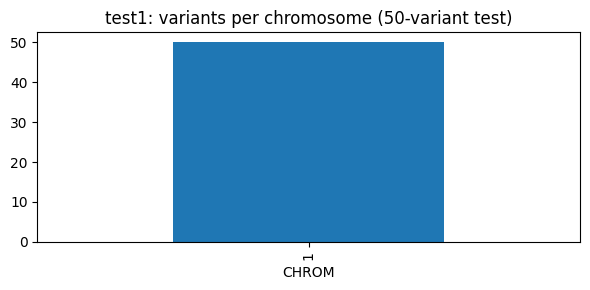

In [20]:
# Cell 10: quick barplot of per-chromosome counts for test1
chr_counts = df1_vars['CHROM'].value_counts()
plt.figure(figsize=(6,3))
chr_counts.plot.bar()
plt.title('test1: variants per chromosome (50-variant test)')
plt.tight_layout()
plt.show()

In [21]:
# Cell 8: Save outputs for reporting (corrected filenames)
df1_ann.to_csv(os.path.join(OUT_DIR, 'test1_first50_annotations_expanded.csv'), index=False)
df2_ann.to_csv(os.path.join(OUT_DIR, 'test2_first50_annotations_expanded.csv'), index=False)

# Summaries
pd.DataFrame([s1]).to_csv(os.path.join(OUT_DIR, 'test1_first50_summary.csv'), index=False)
pd.DataFrame([s2]).to_csv(os.path.join(OUT_DIR, 'test2_first50_summary.csv'), index=False)

# Save pathogenic/high-impact findings
path1.to_csv(os.path.join(OUT_DIR, 'test1_first50_pathogenic_or_highimpact.csv'), index=False)
path2.to_csv(os.path.join(OUT_DIR, 'test2_first50_pathogenic_or_highimpact.csv'), index=False)

print("✅ Saved CSV results to:", OUT_DIR)

✅ Saved CSV results to: /home/user/clovertex_assignment/assignment_1_genomics_annotation/results


In [22]:
import os, pandas as pd

# Define file paths
VCF_DIR = os.path.expanduser('~/clovertex_assignment/vcfs')
test1_vcf = os.path.join(VCF_DIR, 'test1_first50_vep_output.vcf')
test2_vcf = os.path.join(VCF_DIR, 'test2_first50_vep_output.vcf')

# --- Count total records and CSQ occurrences ---
!grep -v '^#' {test1_vcf} | wc -l > /tmp/v1_total.txt
!grep -v '^#' {test1_vcf} | grep -c 'CSQ=' > /tmp/v1_csq.txt
!grep -v '^#' {test2_vcf} | wc -l > /tmp/v2_total.txt
!grep -v '^#' {test2_vcf} | grep -c 'CSQ=' > /tmp/v2_csq.txt

# Read counts from temp files
v1_total = int(open('/tmp/v1_total.txt').read().strip() or 0)
v1_csq = int(open('/tmp/v1_csq.txt').read().strip() or 0)
v2_total = int(open('/tmp/v2_total.txt').read().strip() or 0)
v2_csq = int(open('/tmp/v2_csq.txt').read().strip() or 0)

# --- Compute basic counts & duplicates for annotation dataframes ---
df_counts = {
    'test1': {
        'df_variants': len(df1_vars),
        'df_ann_unique_variants': df1_ann[['CHROM','POS']].drop_duplicates().shape[0],
        'df_ann_rows': len(df1_ann)
    },
    'test2': {
        'df_variants': len(df2_vars),
        'df_ann_unique_variants': df2_ann[['CHROM','POS']].drop_duplicates().shape[0],
        'df_ann_rows': len(df2_ann)
    }
}

# Detect duplicates
d1dup = df1_ann.duplicated(subset=['CHROM','POS']).sum()
d2dup = df2_ann.duplicated(subset=['CHROM','POS']).sum()

print("✅ Variant & annotation summary variables ready:")
print(f"test1_first50: {v1_total} total, {v1_csq} CSQ-tagged")
print(f"test2_first50: {v2_total} total, {v2_csq} CSQ-tagged")

✅ Variant & annotation summary variables ready:
test1_first50: 50 total, 50 CSQ-tagged
test2_first50: 50 total, 50 CSQ-tagged


In [23]:
# Jupyter validation cell: analyze Nextflow VEP outputs and save validation_report
# Paste this whole cell into assignment_1_analysis.ipynb and run

import os, csv, gzip
from pathlib import Path
import pandas as pd

In [24]:
PROJECT = Path.home() / 'clovertex_assignment' / 'assignment_2_nextflow_pipeline'
MANIFEST = PROJECT / 'samples.csv'
RESULTS = PROJECT / 'results'
RESULTS.mkdir(parents=True, exist_ok=True)

In [25]:
def open_text(p):
    if str(p).endswith('.gz'):
        return gzip.open(p, 'rt')
    return open(p, 'r')

def count_non_header(p):
    c = 0
    with open_text(p) as fh:
        for line in fh:
            if not line.startswith('#'):
                c += 1
    return c

In [26]:
def analyze_annotated(p):
    stats = {'annotated_total_records':0,'vcf_records_with_CSQ':0,'csq_header_present':False,
             'annotated_unique_variants_count':0,'csq_entries_total':0,'variants_with_multiple_csq_entries':0}
    per_variant = {}
    uniq = set()
    with open_text(p) as fh:
        for line in fh:
            if line.startswith('##INFO=<ID=CSQ'):
                stats['csq_header_present'] = True
            if not line.startswith('#'):
                cols = line.rstrip().split('\t')
                if len(cols) < 8:
                    continue
                chrom,pos,vid,ref,alt,qual,flt,info = cols[:8]
                stats['annotated_total_records'] += 1
                if 'CSQ=' in info:
                    stats['vcf_records_with_CSQ'] += 1
                    key = (chrom,pos,ref,alt)
                    uniq.add(key)
                    csq = info.split('CSQ=')[1].split(';')[0]
                    n = len(csq.split(',')) if csq else 0
                    stats['csq_entries_total'] += n
                    per_variant[key] = per_variant.get(key,0) + n
    stats['annotated_unique_variants_count'] = len(uniq)
    stats['variants_with_multiple_csq_entries'] = sum(1 for v in per_variant if per_variant[v] > 1)
    return stats

In [27]:
import csv
from pathlib import Path
import pandas as pd
import os

RESULTS = Path('~/clovertex_assignment/assignment_2_nextflow_pipeline/results').expanduser()

# Reopen the manifest file
manifest = Path('~/clovertex_assignment/assignment_2_nextflow_pipeline/samples.csv').expanduser()
with open(manifest) as f:
    reader = list(csv.DictReader(f))  # Convert to list so file can close safely

In [28]:
rows = []

for r in reader:
    sample = r['sample_name']
    raw_path = Path(r['vcf_path'])
    ann_vcf = RESULTS / f"{sample}_vep_output.vcf"

    rec = {
        'sample': sample,
        'vcf_total_records_raw': None,
        'annotated_vcf_path': str(ann_vcf) if ann_vcf.exists() else None,
        'annotated_total_records': None,
        'csq_header_present': False
    }

    # ---- check raw file ----
    if raw_path.exists():
        rec['vcf_total_records_raw'] = sum(
            1 for _ in open(raw_path) if not _.startswith('#')
        )

    # ---- check annotated output ----
    if ann_vcf.exists():
        rec['annotated_total_records'] = sum(
            1 for _ in open(ann_vcf) if not _.startswith('#')
        )
        with open(ann_vcf) as f:
            for line in f:
                if line.startswith('##INFO=<ID=CSQ'):
                    rec['csq_header_present'] = True
                    break

    # ---- notes section ----
    notes = []
    if rec['vcf_total_records_raw'] is not None and rec['annotated_total_records'] is not None:
        if rec['vcf_total_records_raw'] != rec['annotated_total_records']:
            notes.append('raw_vs_annotated_count_mismatch')
    if not rec['annotated_vcf_path']:
        notes.append('annotated_not_found')
    if not rec['csq_header_present']:
        notes.append('CSQ_header_missing')

    rec['note'] = ';'.join(notes) if notes else ''
    rows.append(rec)

# ---- summary output ----
df = pd.DataFrame(rows)
out_csv = RESULTS / 'validation_report_nextflow.csv'
df.to_csv(out_csv, index=False)

print("✅ Saved validation report to:", out_csv)
df


✅ Saved validation report to: /home/user/clovertex_assignment/assignment_2_nextflow_pipeline/results/validation_report_nextflow.csv


,sample,vcf_total_records_raw,annotated_vcf_path,annotated_total_records,csq_header_present,note
0,test1_first50,50,/home/user/clovertex_assignment/assignment_2_n...,50,True,
1,test2_first50,50,/home/user/clovertex_assignment/assignment_2_n...,50,True,
